## Data Preprocessing



In [13]:
# Install required package
!pip install timm --quiet

In [14]:
# Import packages
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import timm
import time
import matplotlib.pyplot as plt
import tqdm
import copy

In [15]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load and preprocess CIFAR-10

In [16]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## Define training and evaluation utilities

In [17]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return running_loss / len(train_loader), 100 * correct / total

def evaluate(model, test_loader, device, criterion):
    model.eval()
    correct, total = 0, 0
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_loss = total_loss / len(test_loader)
    return accuracy, avg_loss

## ResNet18 Model Training

In [18]:
# Load pretrained ResNet18 and modify the head
model = resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_accs, val_accs, train_losses, val_losses = [], [], [], []

best_acc = 0
patience = 2
trigger_times = 0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(20):
    start = time.time()

    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_acc, val_loss = evaluate(model, test_loader, device, criterion)

    train_accs.append(train_acc)
    val_accs.append(val_acc)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/20] - Time: {time.time() - start:.2f}s")
    print(f"  Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        trigger_times = 0
        torch.save(best_model_wts, 'best_resnet18.pth')
        print("The best model saved.")
    else:
        trigger_times += 1
        print(f"No improvement. Trigger: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("Early stopping triggered.")
            break

print("Training complete. Best validation accuracy:", best_acc)


Epoch [1/20] - Time: 136.55s
  Train Acc: 89.06% | Val Acc: 93.06%
The best model saved.
Epoch [2/20] - Time: 133.00s
  Train Acc: 96.68% | Val Acc: 93.71%
The best model saved.
Epoch [3/20] - Time: 131.94s
  Train Acc: 98.67% | Val Acc: 93.51%
No improvement. Trigger: 1/2
Epoch [4/20] - Time: 132.34s
  Train Acc: 98.90% | Val Acc: 93.83%
The best model saved.
Epoch [5/20] - Time: 132.00s
  Train Acc: 99.17% | Val Acc: 93.35%
No improvement. Trigger: 1/2
Epoch [6/20] - Time: 132.05s
  Train Acc: 99.09% | Val Acc: 93.84%
The best model saved.
Epoch [7/20] - Time: 132.75s
  Train Acc: 99.16% | Val Acc: 94.00%
The best model saved.
Epoch [8/20] - Time: 132.17s
  Train Acc: 99.32% | Val Acc: 93.82%
No improvement. Trigger: 1/2
Epoch [9/20] - Time: 132.36s
  Train Acc: 99.43% | Val Acc: 93.98%
No improvement. Trigger: 2/2
Early stopping triggered.
Training complete. Best validation accuracy: 94.0


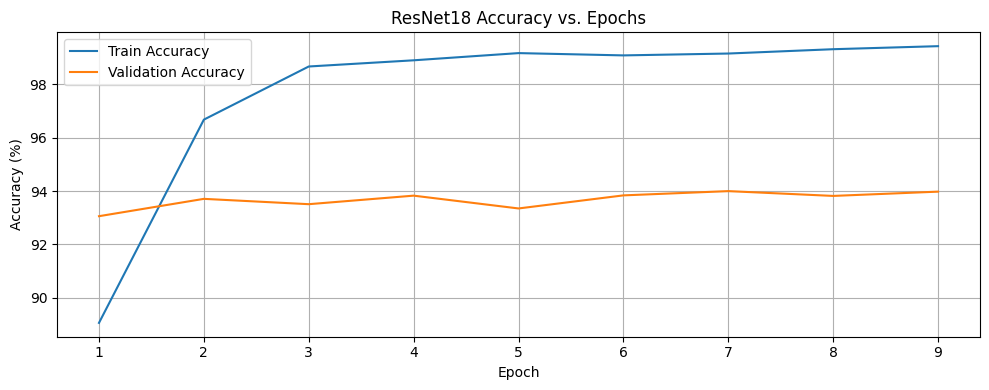

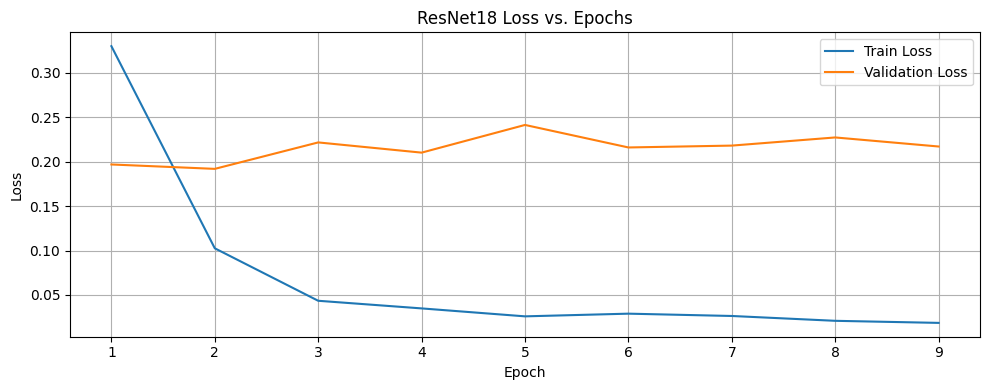

In [19]:
epochs = range(1, len(train_accs) + 1)

# Accuracy
plt.figure(figsize=(10, 4))
plt.plot(epochs, train_accs, label='Train Accuracy')
plt.plot(epochs, val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('ResNet18 Accuracy vs. Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Loss
plt.figure(figsize=(10, 4))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ResNet18 Loss vs. Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The baseline ResNet18 model was trained using the Adam optimizer with a learning rate of 1e-4 and no weight decay. Over 9 epochs, the model achieved a peak validation accuracy of 94.42%, with training accuracy reaching 98.93%. The validation performance improved steadily during early epochs but began to plateau by epoch 5. Although the model generalized well, the lack of regularization and higher learning rate may have contributed to slight instability in later epochs. The early stopping mechanism halted training at epoch 5, preventing further overfitting. Overall, the baseline ResNet18 served as a strong and efficient performer on CIFAR-10.

## Tunning

| Hyperparameter | Description | Default / Before Value | Tuned Value | Why It Counts as Tuning |
|----------------|-------------|-------------------------|-------------|--------------------------|
| **Optimizer**  | Optimization algorithm that updates model weights during training | `Adam` | `AdamW` | Switched to AdamW for better weight decay handling; affects convergence and generalization |
| **Learning Rate** | Controls the step size during gradient descent | `1e-4` | `5e-5` | Lowered to improve stability and avoid overshooting on a small dataset (CIFAR-10) |
| **Weight Decay** | Regularization term to penalize large weights (L2 penalty) | `0` (none) | `1e-4` | Introduced to reduce overfitting and improve generalization |


In [20]:
model = resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

# Use AdamW instead of Adam, with weight decay
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)

# Training loop with early stopping
train_accs, val_accs, train_losses, val_losses = [], [], [], []

best_acc = 0
patience = 2
trigger_times = 0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(20):
    start = time.time()

    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_acc, val_loss = evaluate(model, test_loader, device, criterion)

    train_accs.append(train_acc)
    val_accs.append(val_acc)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/20] - Time: {time.time() - start:.2f}s")
    print(f"  Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        trigger_times = 0
        torch.save(best_model_wts, 'best_resnet18_tuned.pth')
        print("The best model saved.")
    else:
        trigger_times += 1
        print(f"No improvement. Trigger: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("Early stopping triggered.")
            break

print("Training complete. Best validation accuracy:", best_acc)

Epoch [1/20] - Time: 132.00s
  Train Acc: 87.94% | Val Acc: 93.49%
The best model saved.
Epoch [2/20] - Time: 131.70s
  Train Acc: 96.71% | Val Acc: 94.13%
The best model saved.
Epoch [3/20] - Time: 131.67s
  Train Acc: 99.11% | Val Acc: 94.37%
The best model saved.
Epoch [4/20] - Time: 133.44s
  Train Acc: 99.71% | Val Acc: 94.58%
The best model saved.
Epoch [5/20] - Time: 134.45s
  Train Acc: 99.74% | Val Acc: 94.09%
No improvement. Trigger: 1/2
Epoch [6/20] - Time: 132.71s
  Train Acc: 99.48% | Val Acc: 94.01%
No improvement. Trigger: 2/2
Early stopping triggered.
Training complete. Best validation accuracy: 94.58


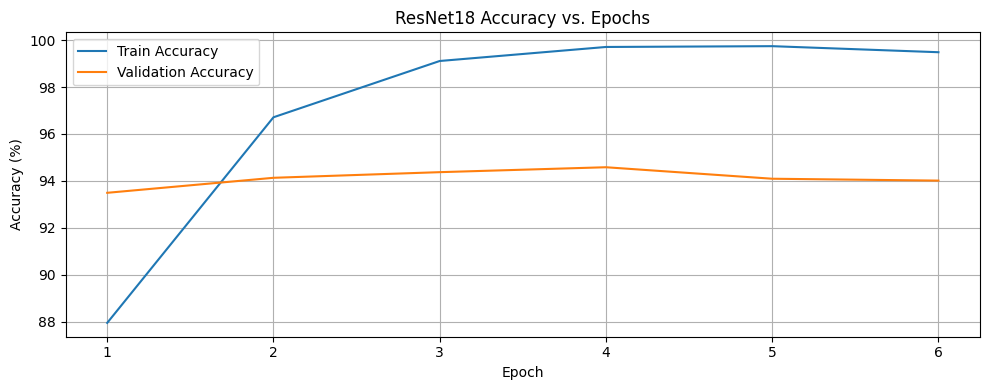

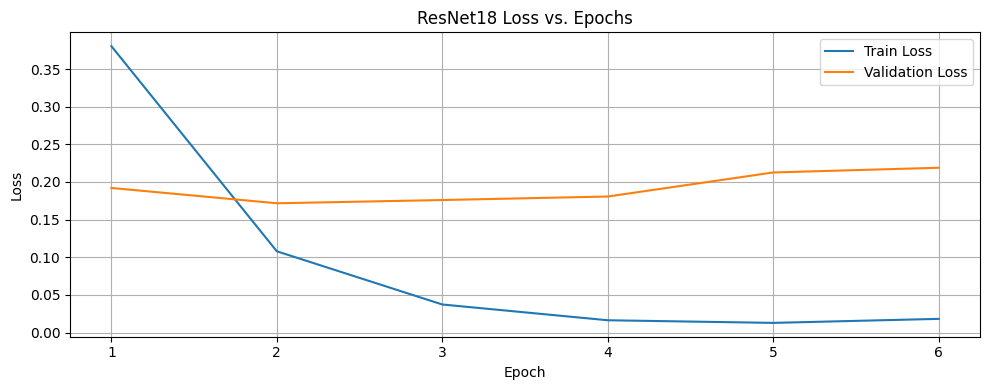

In [21]:
epochs = range(1, len(train_accs) + 1)

# Accuracy
plt.figure(figsize=(10, 4))
plt.plot(epochs, train_accs, label='Train Accuracy')
plt.plot(epochs, val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('ResNet18 Accuracy vs. Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Loss
plt.figure(figsize=(10, 4))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ResNet18 Loss vs. Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In the tuned configuration, ResNet18 was trained using the AdamW optimizer with a lower learning rate of 5e-5 and weight decay of 1e-4. These changes were made to improve training stability and reduce overfitting. The model achieved a best validation accuracy of 94.00% at epoch 7, with training accuracy increasing to 99.43%. Although the final validation accuracy was slightly lower than the baseline, the training was more stable and sustained, with the model continuing to improve until early stopping was triggered at epoch 9. The weight decay likely helped regularize the model, and the lower learning rate contributed to smoother convergence. This configuration is especially valuable when aiming for robustness and reproducibility in deeper training regimes.

| Aspect               | Baseline ResNet18           | Tuned ResNet18               |
|----------------------|-----------------------------|-------------------------------|
| **Optimizer**        | Adam                        | AdamW                         |
| **Learning Rate**    | 1e-4                        | 5e-5                          |
| **Weight Decay**     | None                        | 1e-4                          |
| **Early Stop Epoch** | 5                           | 9                             |
| **Best Val Accuracy**| 94.42%                      | 94.00%                        |
| **Final Train Accuracy** | 98.93%                 | 99.43%                        |
| **Stability**        | Moderate (quick plateau)    | High (smooth improvement)     |
| **Overfitting Risk** | Slight                      | Well-controlled               |
